In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import classification_report,confusion_matrix,recall_score,precision_score,accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample

# PROBLEM
    - Susahnya mencari nasabah, sehingga lebih baik mempertahankan nasabah yang ada.
    - Semakin banyaknya bank, sehingga persaingan juga semakin ketat, sehingga penting untuk mempertahankan nasabah yang sebelumnya sudah memiliki akun di bank kita.

# GOALS
    - Melihat Nasabah mana yang memiliki potensu untuk menutup akunnya, sehingga dapat ditawarkan beberapa hal yang sekiranya dapat membuatnya bertahan.
        - HOW ? ==> Dari historical data, dapat kita klasifikasikan apakah nasabah akan menutup akun mereka atau tidak, dari beberapa feature yang disediakan pada data. Dan akan dibuat model untuk membantu memprediksi kemungkinan tersebut.
     - Akan berfokus pada 1(Exited), sehingga dapat mengantisipasi nasabah untuk keluar, jadi apabila terprediksi akan keluar, mungkin bisa ditawarkan produk menarik. Maka pada kasus klasifikasi ini, pada saat modelling, yang akan difokuskan adalah nilai evaluasi matrix berupa "RECALL", karena akan berbahaya, apabila model memprediksi nasabah kita 0(tidak keluar) padahal aktualnya nasabah tersebut 1(akan keluar)


# FEATURE DESCRIPTION
    X variable :
        1. CustomerId ==> Id dari nasabah
        2. Surname ==> Nama dari nasabah
        3. CreditScore ==> penilaian kredit yang merupakan sistem atau cara yang dipakai oleh suatu lembaga pemberi pinjaman atau bank.
        4. Geography ==> Letak Geografis nasabah
        5. Gender ==> Male/Female
        6. Age ==> Usia
        7. Tenure ==> Sudah berapa lama menjadi nasabah(dalam tahun)
        8. NumOfProducts ==> total produk bank yang digunakan nasabah.
        9. HasCrCard ==> 1 (punya) / 0 (tidak punya)
        10. IsActiveMember ==> 1(aktif) / 0 (tidak aktif)
        11. EstimatedSalary ==> perkiraan salary nasabah
    Y variable (TARGET) :
        1. Exited ==> 1 (tutup akun/akan keluar) / 0 (bertahan)

In [295]:
df = pd.read_csv("./data_exam/bank.csv",index_col="RowNumber")
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerId,10000,NaN,NaN,NaN,1.56909e+07,71936.2,1.55657e+07,1.56285e+07,1.56907e+07,1.57532e+07,1.58157e+07
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000,NaN,NaN,NaN,650.529,96.6533,350,584,652,718,850
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000,NaN,NaN,NaN,38.9218,10.4878,18,32,37,44,92
Tenure,10000,NaN,NaN,NaN,5.0128,2.89217,0,3,5,7,10
Balance,10000,NaN,NaN,NaN,76485.9,62397.4,0,0,97198.5,127644,250898
NumOfProducts,10000,NaN,NaN,NaN,1.5302,0.581654,1,1,1,2,4
HasCrCard,10000,NaN,NaN,NaN,0.7055,0.45584,0,0,1,1,1


In [5]:
age_bin = [10,df.describe(include="all")["Age"]["min"],
           df.describe(include="all")["Age"]["25%"],
           df.describe(include="all")["Age"]["50%"],
           df.describe(include="all")["Age"]["75%"],
           df.describe(include="all")["Age"]["max"]]
label_age = ["Remaja","Dewasa_Tingkat_1","Dewasa_Tingkat_2","Dewasa_Tingkat_3","Dewasa_Tingkat_4"]
df["Age_bin"] = pd.cut(df["Age"],bins=age_bin,labels=label_age)

tenure_bin = [-1,0,df.describe(include="all")["Tenure"]["50%"],
           df.describe(include="all")["Tenure"]["max"]]
label_tenure = ["newbie","junior","senior"]
df["Tenure_bin"] = pd.cut(df["Tenure"],bins=tenure_bin,labels=label_tenure)

In [6]:
df.isna().sum()
## TIDAK ADA MISSING VALUE

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Age_bin            0
Tenure_bin         0
dtype: int64

In [7]:
df["Exited"].value_counts()
## AKAN DILAKUKAN HANDLING IMBALANCE DATA DI BAWAH

0    7963
1    2037
Name: Exited, dtype: int64

# EDA

# EXITED

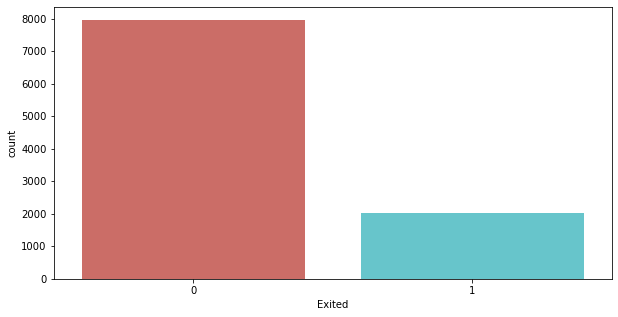

In [8]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=df['Exited'], palette="hls")
plt.show(fig)

In [9]:
pd.crosstab(index=df["Exited"],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

col_0,Jumlah
Exited,
0,7963
1,2037


## CREDIT SCORE

In [10]:
pd.crosstab(index=[df["CreditScore"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
CreditScore,Exited,
850,0,190
678,0,50
850,1,43
684,0,43
655,0,43
667,0,42
670,0,42
633,0,41
660,0,41


In [11]:
pd.crosstab(index=[df[df["Exited"]==0]["CreditScore"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
CreditScore,Exited,
850,0,190
678,0,50
684,0,43
655,0,43
670,0,42
667,0,42
683,0,41
660,0,41
679,0,41


In [12]:
pd.crosstab(index=[df[df["Exited"]==1]["CreditScore"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
CreditScore,Exited,
850,1,43
651,1,17
705,1,16
637,1,14
727,1,13
625,1,13
678,1,13
619,1,12
648,1,12


    Dari EDA untuk Credit Score, tidak terlalu bepengaruh terhadap keluarnya nasabah. Jumlah memang lebih banyak yang bertahan, namum itu dikarenakan datanya memang tidak seimbang antara bertahan dan keluar(1/0 pada feature target)

# GEOGRAPHY

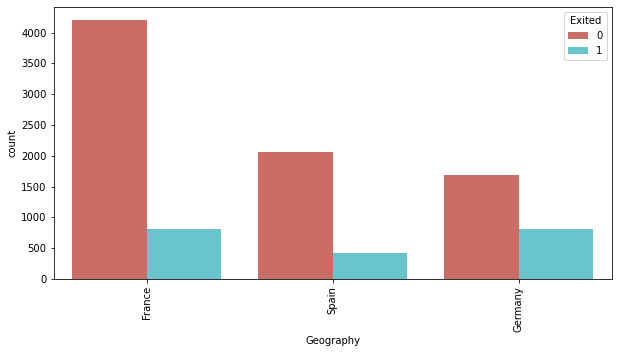

In [13]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=df['Geography'], hue=df['Exited'], palette="hls")
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [14]:
pd.crosstab(index=df["Geography"],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

col_0,Jumlah
Geography,
France,5014
Germany,2509
Spain,2477


In [15]:
pd.crosstab(index=[df[df["Exited"]==1]["Geography"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False)


,col_0,Jumlah
Geography,Exited,
Germany,1,814
France,1,810
Spain,1,413


In [16]:
pd.crosstab(index=[df[df["Exited"]==0]["Geography"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

,col_0,Jumlah
Geography,Exited,
France,0,4204
Spain,0,2064
Germany,0,1695


In [17]:
data_geo = [{
    "German" : (len(df[df["Geography"]=="Germany"][df["Exited"]==1]) / len(df[df["Geography"]=="Germany"])) * 100,
    "Spain" : (len(df[df["Geography"]=="Spain"][df["Exited"]==1]) / len(df[df["Geography"]=="Spain"])) * 100,
    "France": (len(df[df["Geography"]=="France"][df["Exited"]==1]) / len(df[df["Geography"]=="France"])) * 100
}]
pd.DataFrame(data=data_geo,index=["ProbaOut"])

,German,Spain,France
ProbaOut,32.443204,16.673395,16.154767


    Dapat dilihat bahwa nasabah dengan letak geografis German memiliki kecenderungan untuk menutup akun mereka

# GENDER

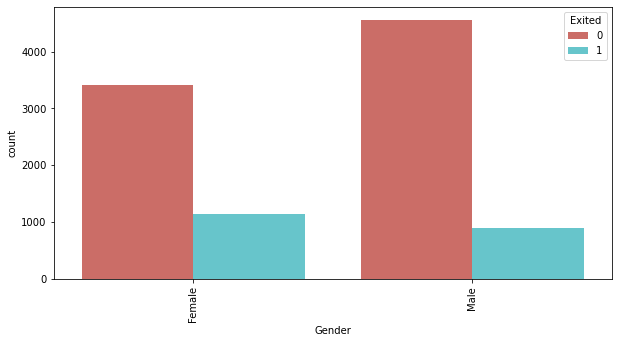

In [18]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=df['Gender'], hue=df['Exited'], palette="hls")
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [19]:
pd.crosstab(index=df["Gender"],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

col_0,Jumlah
Gender,
Male,5457
Female,4543


In [20]:
pd.crosstab(index=[df[df["Exited"]==1]["Gender"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

,col_0,Jumlah
Gender,Exited,
Female,1,1139
Male,1,898


In [21]:
data_gen = [{
    "Female" : (len(df[df["Gender"]=="Female"][df["Exited"]==1]) / len(df[df["Gender"]=="Female"])) * 100,
    "Male" : (len(df[df["Gender"]=="Male"][df["Exited"]==1]) / len(df[df["Gender"]=="Male"])) * 100
}]
pd.DataFrame(data=data_gen,index=["ProbaOut"])

,Female,Male
ProbaOut,25.071539,16.455928


    Dapat dilihat bahwa gender wanita, memiliki kecenderungan lebih tinggu untuk menutup akun mereka

# AGE -- AGE_BIN
    Remaja : 10 - 18
    Dewasa_Tingkat_1 : 19 - 32
    Dewasa_Tingkat_2 : 33 - 37
    Dewasa_Tingkat_3 : 38 - 44
    Dewasa_Tingkat_4 : 45 - 92

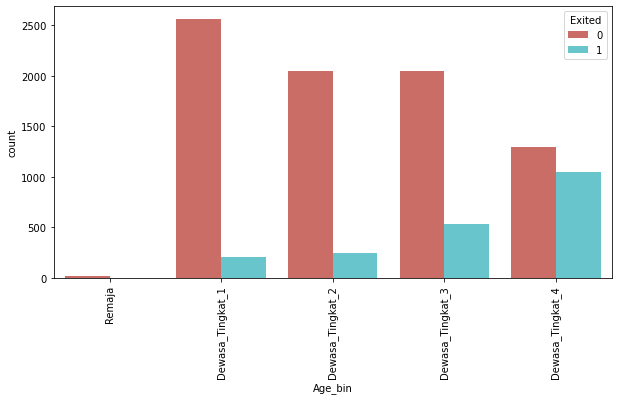

In [22]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=df['Age_bin'], hue=df['Exited'], palette="hls")
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [23]:
pd.crosstab(index=df["Age_bin"],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

col_0,Jumlah
Age_bin,
Dewasa_Tingkat_1,2768
Dewasa_Tingkat_3,2573
Dewasa_Tingkat_4,2340
Dewasa_Tingkat_2,2297
Remaja,22


In [24]:
pd.crosstab(index=[df[df["Exited"]==1]["Age_bin"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False)


,col_0,Jumlah
Age_bin,Exited,
Dewasa_Tingkat_4,1,1044
Dewasa_Tingkat_3,1,531
Dewasa_Tingkat_2,1,249
Dewasa_Tingkat_1,1,211
Remaja,1,2


In [25]:
data_age = [{
    "Remaja" : (len(df[df["Age_bin"]=="Remaja"][df["Exited"]==1]) / len(df[df["Age_bin"]=="Remaja"])) * 100,
    "Dewasa_Tingkat_1" : (len(df[df["Age_bin"]=="Dewasa_Tingkat_1"][df["Exited"]==1]) / len(df[df["Age_bin"]=="Dewasa_Tingkat_1"])) * 100,
    "Dewasa_Tingkat_2" : (len(df[df["Age_bin"]=="Dewasa_Tingkat_2"][df["Exited"]==1]) / len(df[df["Age_bin"]=="Dewasa_Tingkat_2"])) * 100,
    "Dewasa_Tingkat_3" : (len(df[df["Age_bin"]=="Dewasa_Tingkat_3"][df["Exited"]==1]) / len(df[df["Age_bin"]=="Dewasa_Tingkat_3"])) * 100,
    "Dewasa_Tingkat_4" : (len(df[df["Age_bin"]=="Dewasa_Tingkat_4"][df["Exited"]==1]) / len(df[df["Age_bin"]=="Dewasa_Tingkat_4"])) * 100,
}]
pd.DataFrame(data=data_age,index=["ProbaOut"])

,Remaja,Dewasa_Tingkat_1,Dewasa_Tingkat_2,Dewasa_Tingkat_3,Dewasa_Tingkat_4
ProbaOut,9.090909,7.622832,10.840226,20.637388,44.615385


    Nasabah dengan age_bin Dewasa tingkat 4 ( 45-92 tahun) cenderung lebih mungkin untuk menutup akun mereka.

# TENURE - TENURE_BIN

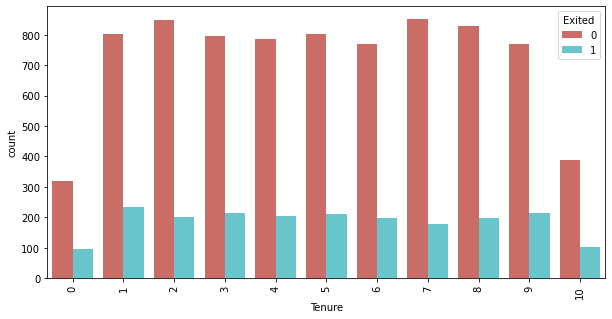

In [26]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=df['Tenure'], hue=df['Exited'], palette="hls")
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

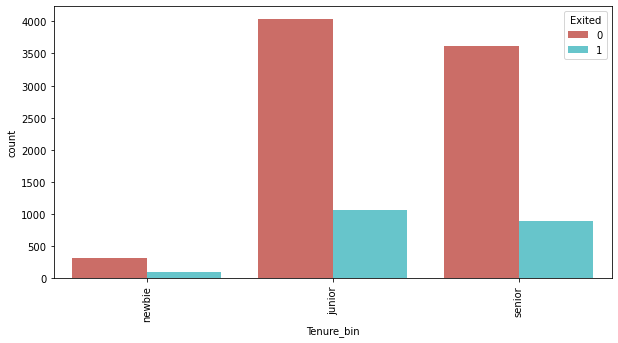

In [27]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=df['Tenure_bin'], hue=df['Exited'], palette="hls")
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [28]:
pd.crosstab(index=df["Tenure_bin"],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

col_0,Jumlah
Tenure_bin,
junior,5093
senior,4494
newbie,413


In [29]:
pd.crosstab(index=[df[df["Exited"]==1]["Tenure_bin"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

,col_0,Jumlah
Tenure_bin,Exited,
junior,1,1058
senior,1,884
newbie,1,95


In [30]:
data_ten = [{
    "Newbie" : (len(df[df["Tenure_bin"]=="newbie"][df["Exited"]==1]) / len(df[df["Tenure_bin"]=="newbie"])) * 100,
    "Junior" : (len(df[df["Tenure_bin"]=="junior"][df["Exited"]==1]) / len(df[df["Tenure_bin"]=="junior"])) * 100,
    "Senior" : (len(df[df["Tenure_bin"]=="senior"][df["Exited"]==1]) / len(df[df["Tenure_bin"]=="senior"])) * 100
}]
pd.DataFrame(data=data_ten,index=["ProbaOut"])

,Newbie,Junior,Senior
ProbaOut,23.002421,20.773611,19.670672


    untuk feature tenure bin(dibawah 1 tahun) memiliki probabilitas untuk menutup akun mereka, lebih besar dibanding junior dan senior, walaupuun perbedaannya tidak signifikan.

# BALANCE

In [31]:
pd.crosstab(index=[df["Balance"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0             Jumlah
Balance   Exited        
0.00      0         3117
          1          500
130170.82 0            2
132178.67 0            1
132174.41 0            1
132168.28 0            1
132164.26 0            1
132150.26 0            1
132144.35 0            1
132129.72 0            1

In [32]:
pd.crosstab(index=[df[df["Exited"]==0]["Balance"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
Balance,Exited,
0.00,0,3117
130170.82,0,2
132371.30,0,1
132576.25,0,1
132527.90,0,1
132512.26,0,1
132450.24,0,1
132439.99,0,1
132436.34,0,1


In [33]:
pd.crosstab(index=[df[df["Exited"]==1]["Balance"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
Balance,Exited,
0.00,1,500
137986.58,1,1
131593.85,1,1
131583.59,1,1
131441.51,1,1
131433.33,1,1
131394.56,1,1
131368.30,1,1
131355.30,1,1


    belum begitu kelihatan dari feature balance, memiliki pengaruh atau tidak.

# NUMOFPRODUCTS

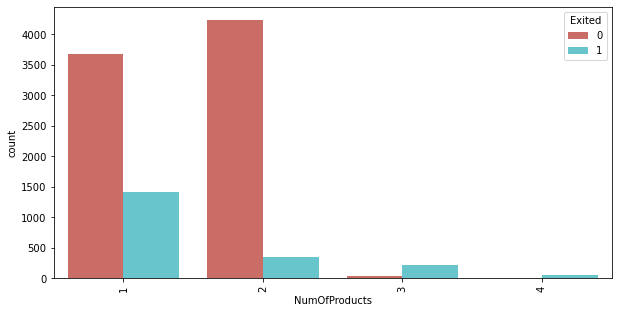

In [34]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=df['NumOfProducts'], hue=df['Exited'], palette="hls")
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [35]:
pd.crosstab(index=df["NumOfProducts"],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

col_0,Jumlah
NumOfProducts,
1,5084
2,4590
3,266
4,60


In [36]:
pd.crosstab(index=[df[df["Exited"]==1]["NumOfProducts"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

,col_0,Jumlah
NumOfProducts,Exited,
1,1,1409
2,1,348
3,1,220
4,1,60


In [37]:
data_pro = [{
    "1" : (len(df[df["NumOfProducts"]==1][df["Exited"]==1]) / len(df[df["NumOfProducts"]==1])) * 100,
    "2" : (len(df[df["NumOfProducts"]==2][df["Exited"]==1]) / len(df[df["NumOfProducts"]==2])) * 100,
    "3": (len(df[df["NumOfProducts"]==3][df["Exited"]==1]) / len(df[df["NumOfProducts"]==3])) * 100,
    "4": (len(df[df["NumOfProducts"]==4][df["Exited"]==1]) / len(df[df["NumOfProducts"]==4])) * 100
}]
pd.DataFrame(data=data_pro,index=["ProbaOut"])

,1,2,3,4
ProbaOut,27.714398,7.581699,82.706767,100.0


    makin banyak produk yang diambil nasabah, nasabah cenderung akan menutup akun mereka, seperti jumlah produk 3 dan 4, bahkan 4 ==> 100%

# HASCRCARD

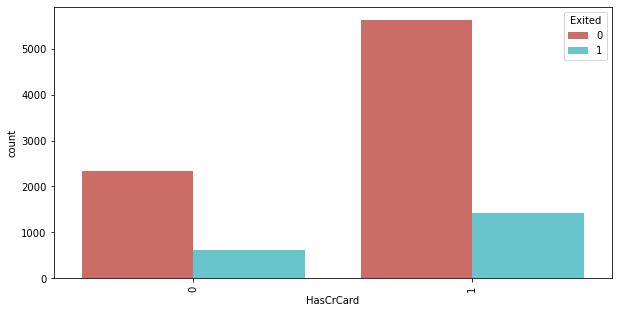

In [38]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=df['HasCrCard'], hue=df['Exited'], palette="hls")
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [39]:
pd.crosstab(index=df["HasCrCard"],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

col_0,Jumlah
HasCrCard,
1,7055
0,2945


In [40]:
pd.crosstab(index=[df[df["Exited"]==1]["HasCrCard"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False)


,col_0,Jumlah
HasCrCard,Exited,
1,1,1424
0,1,613


In [41]:
data_card = [{
    "Card" : (len(df[df["HasCrCard"]==1][df["Exited"]==1]) / len(df[df["HasCrCard"]==1])) * 100,
    "No Card" : (len(df[df["HasCrCard"]==0][df["Exited"]==1]) / len(df[df["HasCrCard"]==0])) * 100
}]
pd.DataFrame(data=data_card,index=["ProbaOut"])

,Card,No Card
ProbaOut,20.184266,20.814941


    feature HasCrCard tidak terlalu memiliki pengaruh signifikan, probabilitynya beda sangat sedikit

# ISACTIVEMEMBER

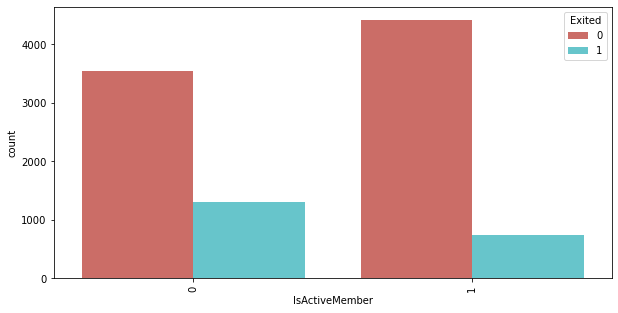

In [42]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=df['IsActiveMember'], hue=df['Exited'], palette="hls")
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [43]:
pd.crosstab(index=df["IsActiveMember"],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

col_0,Jumlah
IsActiveMember,
1,5151
0,4849


In [44]:
pd.crosstab(index=[df[df["Exited"]==1]["IsActiveMember"],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False)

,col_0,Jumlah
IsActiveMember,Exited,
0,1,1302
1,1,735


In [45]:
data_mem = [{
    "Active" : (len(df[df["IsActiveMember"]==1][df["Exited"]==1]) / len(df[df["IsActiveMember"]==1])) * 100,
    "Passive" : (len(df[df["IsActiveMember"]==0][df["Exited"]==1]) / len(df[df["IsActiveMember"]==0])) * 100
}]
pd.DataFrame(data=data_mem,index=["ProbaOut"])

,Active,Passive
ProbaOut,14.269074,26.850897


    yang merupakan nasabah passive, memiliki probabilitas untuk menutup akun mereka, lebih tinggi daripada member yang aktif

# ESTIMATEDSALERY

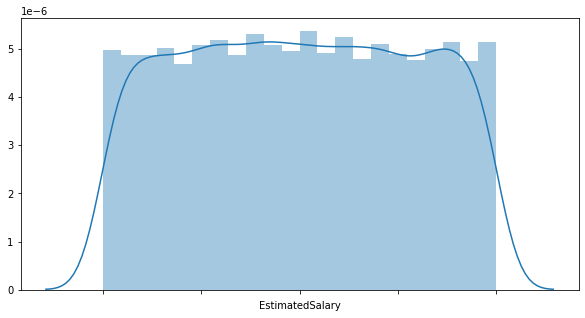

In [46]:
plt.figure(figsize=(10,5))
fig = sns.distplot(df['EstimatedSalary'])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [47]:
pd.crosstab(index=[df['EstimatedSalary'],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
EstimatedSalary,Exited,
24924.92,0,2
132908.07,0,1
132741.13,1,1
132770.11,0,1
132798.78,0,1
132801.57,0,1
132809.18,0,1
132861.90,1,1
132870.15,0,1


In [48]:
pd.crosstab(index=[df[df["Exited"]==1]['EstimatedSalary'],df["Exited"]],columns="Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
EstimatedSalary,Exited,
11.58,1,1
135163.76,1,1
136507.69,1,1
136458.19,1,1
136365.00,1,1
136119.96,1,1
136079.64,1,1
136050.44,1,1
135875.51,1,1


# FEATURE ENGINEERING & FEATURE SELECTION

In [49]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_bin,Tenure_bin
RowNumber,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Dewasa_Tingkat_3,junior
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Dewasa_Tingkat_3,junior
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Dewasa_Tingkat_3,senior
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Dewasa_Tingkat_3,junior
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Dewasa_Tingkat_3,junior


In [50]:
df = df.drop(columns=["Age_bin","Tenure_bin"])
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


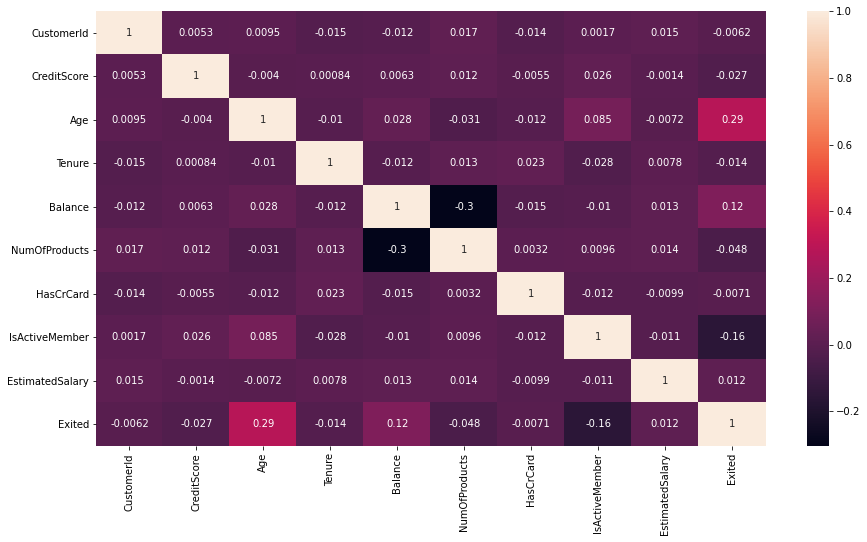

In [51]:
plt.figure(figsize=(15,8))
fig = sns.heatmap(data=df.corr(),annot=True)

    Dari korelasi, tidak kelihatan karena semua memiliki korelasi rendah, jadi Feature selection akan dilakukan berdasarkan pemahaman pribadi dan EDA
<br>
    
    Kolom yang akan didrop :
        1. CustomerId ==> karena merupakan unique number, dan menurut saya tidak ada pengaruhnya terhadao target
        2. Surname ==> Menurut saya juga tidak ada pengaruhnya, selain itu korelasi juga rendah
        3. HasCrCard ==> dari EDA terlihat tidak terlalu berpengaruh, karena bedanya tidak signifikan antara yang memiliki karti kredit dan tidak memiliki kartu kredit.

In [52]:
df = df.drop(columns=["CustomerId","Surname","HasCrCard"])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,79084.10,0


## HANDLE IMBALANCE DATA -- RANDOM OVER SAMPLING
    - Saya pilih menggunakan Random Over Sampling dibanding SMOTE , karena lebih aman ==> Pada random over sampling, akan dilakukan duplikat data yang sudahh ada. Apabila SMOTE ==> akan dibuat data sintetis, karena lumayan banyak ada sekitar 5000an data yang akan dibuat agar balance, jadi susah untuk mengontrol data sintetisnya apakah isi datanya legal/tidak ==> misalnya saja feature umur, takut terjadi outliers, misalnya data sintetisnya menjadi 700, padahal umur normal manusia dibawah 100. 

In [53]:
(df['Exited'].value_counts()/len(df)*100).round(2)

0    79.63
1    20.37
Name: Exited, dtype: float64

In [54]:
exited = df[df['Exited'] == 1]
not_exited = df[df["Exited"] == 0] 

exited_oversample = resample(exited,
                           replace = True,
                           n_samples = len(not_exited),
                           random_state = 42)

In [55]:
df_new= pd.concat([not_exited,exited_oversample])
(df_new['Exited'].value_counts()/len(df_new)*100).round(2)

1    50.0
0    50.0
Name: Exited, dtype: float64

In [56]:
df_new

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,
2,608,Spain,Female,41,1,83807.86,1,1,112542.58,0
4,699,France,Female,39,1,0.00,2,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,79084.10,0
7,822,France,Male,50,7,0.00,2,1,10062.80,0
9,501,France,Male,44,4,142051.07,2,1,74940.50,0
...,...,...,...,...,...,...,...,...,...,...
5702,625,Germany,Female,49,4,128504.76,1,0,126812.63,1
9338,466,Germany,Female,47,5,102085.72,1,1,183536.24,1
4346,720,Germany,Male,46,3,97042.60,1,1,133516.51,1


## BINNING FEATURE :
    1. Geography
    2. Gender

In [57]:
df_new["Geography"] = df_new["Geography"].map({
    "Spain" : 0,
    "France" : 1,
    "Germany" : 2
})
df_new["Gender"] = df_new["Gender"].map({
    "Female" : 0,
    "Male" : 1
})

In [59]:
df_new.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,
2,608,0,0,41,1,83807.86,1,1,112542.58,0
4,699,1,0,39,1,0.00,2,0,93826.63,0
5,850,0,0,43,2,125510.82,1,1,79084.10,0
7,822,1,1,50,7,0.00,2,1,10062.80,0
9,501,1,1,44,4,142051.07,2,1,74940.50,0


In [63]:
df_new = pd.get_dummies(data=df_new,columns=["Geography","Gender"],prefix_sep="_")

In [64]:
df_new

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Geography_0,Geography_1,Geography_2,Gender_0,Gender_1
RowNumber,,,,,,,,,,,,,
2,608,41,1,83807.86,1,1,112542.58,0,1,0,0,1,0
4,699,39,1,0.00,2,0,93826.63,0,0,1,0,1,0
5,850,43,2,125510.82,1,1,79084.10,0,1,0,0,1,0
7,822,50,7,0.00,2,1,10062.80,0,0,1,0,0,1
9,501,44,4,142051.07,2,1,74940.50,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702,625,49,4,128504.76,1,0,126812.63,1,0,0,1,1,0
9338,466,47,5,102085.72,1,1,183536.24,1,0,0,1,1,0
4346,720,46,3,97042.60,1,1,133516.51,1,0,0,1,0,1


In [67]:
x = df_new.drop(columns="Exited")
y = df_new["Exited"]

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,stratify=y,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((12740, 12), (3186, 12), (12740,), (3186,))

# BASE MODEL :
    1. KNN
    2. RANDOM FOREST
    3. XGBOOST

## KNN

In [68]:
KNN = KNeighborsClassifier()

In [69]:
KNN.fit(x_train,y_train)

KNeighborsClassifier()

In [70]:
y_KNN_train = KNN.predict(x_train)
y_KNN_test = KNN.predict(x_test)

In [71]:
accuracy_KNN_train = accuracy_score(y_train,y_KNN_train)
precision_KNN_train = precision_score(y_train,y_KNN_train)
recall_KNN_train = recall_score(y_train,y_KNN_train)
f1_KNN_train = f1_score(y_train,y_KNN_train)

accuracy_KNN_test = accuracy_score(y_test,y_KNN_test)
precision_KNN_test = precision_score(y_test,y_KNN_test)
recall_KNN_test = recall_score(y_test,y_KNN_test)
f1_KNN_test = f1_score(y_test,y_KNN_test)

In [72]:
print("EVALUATION MATRIX KNN :")
print("Accuracy = ",accuracy_KNN_train," VS ",accuracy_KNN_test)
print("Precision = ",precision_KNN_train," VS ",precision_KNN_test)
print("Recall = ",recall_KNN_train," VS ",recall_KNN_test)
print("F1_Score = ",f1_KNN_train," VS ",f1_KNN_test)

EVALUATION MATRIX KNN :
Accuracy =  0.8116954474097331  VS  0.694601381042059
Precision =  0.7536731825731442  VS  0.6519607843137255
Recall =  0.9260596546310832  VS  0.834902699309479
F1_Score =  0.8310206381629922  VS  0.7321772639691715


In [73]:
cm_KNN = confusion_matrix(y_test,y_KNN_test,labels=[1,0])
df_cm_KNN = pd.DataFrame(data=cm_KNN,columns=["Pred_1","Pred_0"],index=["Aktual_1","Aktual_0"])
df_cm_KNN

,Pred_1,Pred_0
Aktual_1,1330,263
Aktual_0,710,883


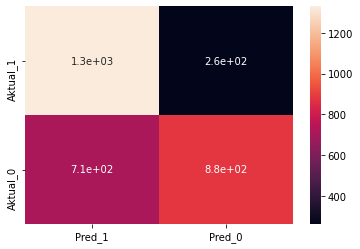

In [74]:
sns.heatmap(df_cm_KNN,annot=True)

    Untuk Hasil recall KNN base model, sudah bagus, namun masih overfit. Kemudian untuk False negatif masih lumayan tinggi, di angka 263 ==> jadi ada 263 nasabah yang sebenarnya akan menutup akun mereka, tapi model memprediksi nasabah tersebut tidak akan menutup akun mereka.

## KNN -- SCALED
    AKAN DILAKUKAN SCALING, KARENA KNN BERBASIS JARAK, SEHINGGA PROPORSI SETIAP FEATURE HARUS SEIMBANG

In [76]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [77]:
KNN_Scaled = KNeighborsClassifier()

In [78]:
KNN_Scaled.fit(x_train_scaled,y_train)

KNeighborsClassifier()

In [79]:
y_KNN_train_scaled = KNN_Scaled.predict(x_train_scaled)
y_KNN_test_scaled = KNN_Scaled.predict(x_test_scaled)

In [83]:
accuracy_KNN_train_scaled = accuracy_score(y_train,y_KNN_train_scaled)
precision_KNN_train_scaled = precision_score(y_train,y_KNN_train_scaled)
recall_KNN_train_scaled = recall_score(y_train,y_KNN_train_scaled)
f1_KNN_train_scaled = f1_score(y_train,y_KNN_train_scaled)

accuracy_KNN_test_scaled = accuracy_score(y_test,y_KNN_test_scaled)
precision_KNN_test_scaled = precision_score(y_test,y_KNN_test_scaled)
recall_KNN_test_scaled = recall_score(y_test,y_KNN_test_scaled)
f1_KNN_test_scaled = f1_score(y_test,y_KNN_test_scaled)

In [84]:
print("EVALUATION MATRIX KNN SCALED :")
print("Accuracy = ",accuracy_KNN_train_scaled," VS ",accuracy_KNN_test_scaled)
print("Precision = ",precision_KNN_train_scaled," VS ",precision_KNN_test_scaled)
print("Recall = ",recall_KNN_train_scaled," VS ",recall_KNN_test_scaled)
print("F1_Score = ",f1_KNN_train_scaled," VS ",f1_KNN_test_scaled)

EVALUATION MATRIX KNN SCALED :
Accuracy =  0.8824175824175824  VS  0.825172630257376
Precision =  0.839086859688196  VS  0.7734952481520592
Recall =  0.9463108320251178  VS  0.9196484620213434
F1_Score =  0.8894791205548177  VS  0.840263837109263


In [85]:
cm_KNN_scaled = confusion_matrix(y_test,y_KNN_test_scaled,labels=[1,0])
df_cm_KNN_scaled = pd.DataFrame(data=cm_KNN_scaled,columns=["Pred_1","Pred_0"],index=["Aktual_1","Aktual_0"])
df_cm_KNN_scaled

,Pred_1,Pred_0
Aktual_1,1465,128
Aktual_0,429,1164


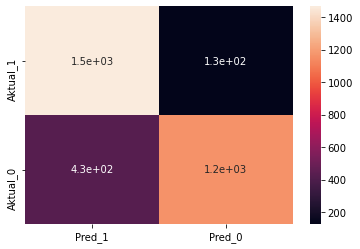

In [86]:
sns.heatmap(df_cm_KNN_scaled,annot=True)

    Untuk hasil recall pada KNN scaledm sudah cukup bagus dan tidak overfit. Kemudian, untuk confusion matrix sudah banyak penuruan (FALSE NEGATIVE) dari yang sebelum di scaling FN = 263 , setelah di scaling FN = 128

## RANDOM FOREST

In [87]:
RF = RandomForestClassifier()

In [88]:
RF.fit(x_train,y_train)

RandomForestClassifier()

In [89]:
y_RF_train = RF.predict(x_train)
y_RF_test = RF.predict(x_test)

In [90]:
accuracy_RF_train = accuracy_score(y_train,y_RF_train)
precision_RF_train= precision_score(y_train,y_RF_train)
recall_RF_train = recall_score(y_train,y_RF_train)
f1_RF_train = f1_score(y_train,y_RF_train)

accuracy_RF_test = accuracy_score(y_test,y_RF_test)
precision_RF_test= precision_score(y_test,y_RF_test)
recall_RF_test = recall_score(y_test,y_RF_test)
f1_RF_test = f1_score(y_test,y_RF_test)

In [91]:
print("EVALUATION MATRIX RANDOM FOREST :")
print("Accuracy = ",accuracy_RF_train," VS ",accuracy_RF_test)
print("Precision = ",precision_RF_train," VS ",precision_RF_test)
print("Recall = ",recall_RF_train," VS ",recall_RF_test)
print("F1_Score = ",f1_RF_train," VS ",f1_RF_test)

EVALUATION MATRIX RANDOM FOREST :
Accuracy =  1.0  VS  0.9522912743251726
Precision =  1.0  VS  0.9255759007678677
Recall =  1.0  VS  0.9836785938480854
F1_Score =  1.0  VS  0.9537431527693244


In [92]:
cm_RF = confusion_matrix(y_test,y_RF_test,labels=[1,0])
df_cm_RF = pd.DataFrame(data=cm_RF,columns=["Pred_1","Pred_0"],index=["Aktual_1","Aktual_0"])
df_cm_RF

,Pred_1,Pred_0
Aktual_1,1567,26
Aktual_0,126,1467


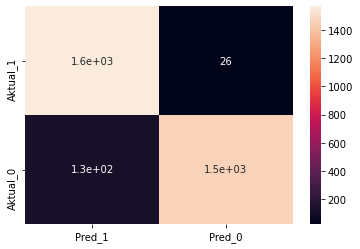

In [93]:
sns.heatmap(df_cm_RF,annot=True)

     Hasil recallnya terlalu bagus dan tidak overfit, akan dilakukan tunning sedikit untuk menurunkan recall pada model. Kemudian untuk Confusion matrix nya sendiri sudah bagus, karena FN nya renda ==>26

## XGBOOST

In [94]:
XGB = XGBClassifier()

In [95]:
XGB.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [96]:
y_XGB_train = XGB.predict(x_train)
y_XGB_test = XGB.predict(x_test)

In [99]:
accuracy_XGB_train = accuracy_score(y_train,y_XGB_train)
precision_XGB_train= precision_score(y_train,y_XGB_train)
recall_XGB_train = recall_score(y_train,y_XGB_train)
f1_XGB_train= f1_score(y_train,y_XGB_train)

accuracy_XGB_test = accuracy_score(y_test,y_XGB_test)
precision_XGB_test= precision_score(y_test,y_XGB_test)
recall_XGB_test = recall_score(y_test,y_XGB_test)
f1_XGB_test = f1_score(y_test,y_XGB_test)

In [100]:
print("EVALUATION MATRIX EXTREME GRADIENT BOOSTING :")
print("Accuracy = ",accuracy_XGB_train," VS ",accuracy_XGB_test)
print("Precision = ",precision_XGB_train," VS ",precision_XGB_test)
print("Recall = ",recall_XGB_train," VS ",recall_XGB_test)
print("F1_Score = ",f1_XGB_train," VS ",f1_XGB_test)

EVALUATION MATRIX EXTREME GRADIENT BOOSTING :
Accuracy =  0.9554160125588697  VS  0.89924670433145
Precision =  0.9471331689272503  VS  0.8714953271028038
Recall =  0.9646781789638933  VS  0.9365976145637163
F1_Score =  0.9558251672110749  VS  0.902874432677761


In [101]:
cm_XGB = confusion_matrix(y_test,y_XGB_test,labels=[1,0])
df_cm_XGB = pd.DataFrame(data=cm_XGB,columns=["Pred_1","Pred_0"],index=["Aktual_1","Aktual_0"])
df_cm_XGB

,Pred_1,Pred_0
Aktual_1,1492,101
Aktual_0,220,1373


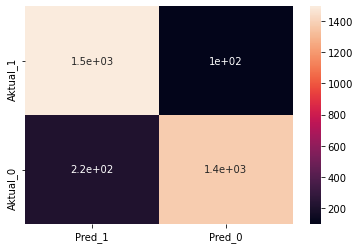

In [102]:
sns.heatmap(df_cm_XGB,annot=True)

    Hasil recall pada XGBOOST base model sudah bagus dan tidak overfitting, dan untuk Confusion matrix, FN juga sudah cenderung rendah

# ======== HYPER PARAMETER TUNING ==========

## KNN_SCALED_TUNED

In [147]:
KNN_Tuned = KNeighborsClassifier()

In [148]:
parameter_KNN = {
    "n_neighbors" : [3,5,7,9],
    "weights" : ["uniform"],
    "p" : [1,2]
}

In [149]:
model_KNN_Tuned = GridSearchCV(estimator=KNN_Tuned,
                    param_grid = parameter_KNN,
                    n_jobs = -1,
                    cv = 7,
                    verbose = 1 
                    )

In [150]:
model_KNN_Tuned.fit(x_train_scaled,y_train)

Fitting 7 folds for each of 8 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    2.6s finished


GridSearchCV(cv=7, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform']},
             verbose=1)

In [151]:
model_KNN_Tuned.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [152]:
KNN_Tuned = model_KNN_Tuned.best_estimator_

In [153]:
y_KNN_Tuned_train = KNN_Tuned.predict(x_train_scaled)
y_KNN_Tuned_test = KNN_Tuned.predict(x_test_scaled)

In [154]:
accuracy_KNN_Tuned_train= accuracy_score(y_train,y_KNN_Tuned_train)
precision_KNN_Tuned_train= precision_score(y_train,y_KNN_Tuned_train)
recall_KNN_Tuned_train = recall_score(y_train,y_KNN_Tuned_train)
f1_KNN_Tuned_train = f1_score(y_train,y_KNN_Tuned_train)

accuracy_KNN_Tuned_test = accuracy_score(y_test,y_KNN_Tuned_test)
precision_KNN_Tuned_test = precision_score(y_test,y_KNN_Tuned_test)
recall_KNN_Tuned_test = recall_score(y_test,y_KNN_Tuned_test)
f1_KNN_Tuned_test = f1_score(y_test,y_KNN_Tuned_test)

In [155]:
print("EVALUATION MATRIX KNN TUNED :")
print("Accuracy = ",accuracy_KNN_Tuned_train," VS ",accuracy_KNN_Tuned_test)
print("Precision = ",precision_KNN_Tuned_train," VS ",precision_KNN_Tuned_test)
print("Recall = ",recall_KNN_Tuned_train," VS ",recall_KNN_Tuned_test)
print("F1_Score = ",f1_KNN_Tuned_train," VS ",f1_KNN_Tuned_test)

EVALUATION MATRIX KNN TUNED :
Accuracy =  0.9282574568288854  VS  0.8615819209039548
Precision =  0.8844419391206313  VS  0.8044397463002114
Recall =  0.985243328100471  VS  0.9554300062774639
F1_Score =  0.9321253527402347  VS  0.873457675753228


In [156]:
cm_KNN_Tuned = confusion_matrix(y_test,y_KNN_Tuned_test,labels=[1,0])
df_cm_KNN_Tuned = pd.DataFrame(data=cm_KNN_Tuned,columns=["Pred_1","Pred_0"],index=["Aktual_1","Aktual_0"])
df_cm_KNN_Tuned

,Pred_1,Pred_0
Aktual_1,1522,71
Aktual_0,370,1223


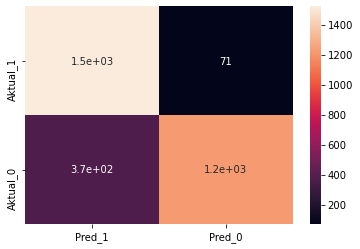

In [157]:
sns.heatmap(df_cm_KNN_Tuned,annot=True)

    Hasil recall untuk KNN sudah bagus dan tidak overfit setelah di tuning, namun sengaja pada parameter weight==>"distance" tidak saya gunakan, karena semua train setelah digunakan distance menjadi terlalu sempurna yaitu 1. Kemudian untuk confusion matrix juga sudah menurun dari KNN scaled yang sebelumnya, yang awalnya FN = 128 , setelah di tuning, FN = 71

## RANDOM FOREST TUNED

In [221]:
RF_Tuned = RandomForestClassifier()

In [222]:
parameter_RF ={
    "n_estimators" : [100,200],
    "max_depth" : [None],
    "min_samples_split" : [2,4,6],
    "min_samples_leaf" : [1,2,3],
    "max_features" : ["auto"]
}

In [223]:
model_RF_Tuned = GridSearchCV(estimator = RF_Tuned,
                       param_grid= parameter_RF,
                       cv = 4,
                       n_jobs = -1,
                       verbose=1)

In [224]:
model_RF_Tuned.fit(x_train,y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   20.0s finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None], 'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200]},
             verbose=1)

In [225]:
model_RF_Tuned.best_estimator_

RandomForestClassifier(n_estimators=200)

In [226]:
RF_Tuned = model_RF_Tuned.best_estimator_

In [227]:
y_RF_Tuned_train = RF_Tuned.predict(x_train)
y_RF_Tuned_test = RF_Tuned.predict(x_test)

In [228]:
accuracy_RF_Tuned_train = accuracy_score(y_train,y_RF_Tuned_train)
precision_RF_Tuned_train= precision_score(y_train,y_RF_Tuned_train)
recall_RF_Tuned_train = recall_score(y_train,y_RF_Tuned_train)
f1_RF_Tuned_train = f1_score(y_train,y_RF_Tuned_train)

accuracy_RF_Tuned_test = accuracy_score(y_test,y_RF_Tuned_test)
precision_RF_Tuned_test= precision_score(y_test,y_RF_Tuned_test)
recall_RF_Tuned_test = recall_score(y_test,y_RF_Tuned_test)
f1_RF_Tuned_test = f1_score(y_test,y_RF_Tuned_test)

In [229]:
print("EVALUATION MATRIX RANDOM FOREST TUNED:")
print("Accuracy = ",accuracy_RF_Tuned_train," VS ",accuracy_RF_Tuned_test)
print("Precision = ",precision_RF_Tuned_train," VS ",precision_RF_Tuned_test)
print("Recall = ",recall_RF_Tuned_train," VS ",recall_RF_Tuned_test)
print("F1_Score = ",f1_RF_Tuned_train," VS ",f1_RF_Tuned_test)

EVALUATION MATRIX RANDOM FOREST TUNED:
Accuracy =  1.0  VS  0.9560577526679221
Precision =  1.0  VS  0.9296274393849793
Recall =  1.0  VS  0.9868173258003766
F1_Score =  1.0  VS  0.9573690621193667


In [230]:
cm_RF_Tuned = confusion_matrix(y_test,y_RF_Tuned_test,labels=[1,0])
df_cm_RF_Tuned = pd.DataFrame(data=cm_RF_Tuned,columns=["Pred_1","Pred_0"],index=["Aktual_1","Aktual_0"])
df_cm_RF_Tuned

,Pred_1,Pred_0
Aktual_1,1572,21
Aktual_0,119,1474


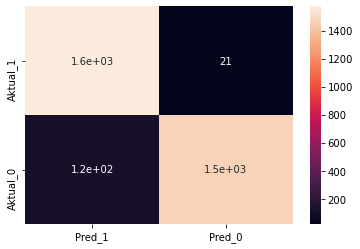

In [231]:
sns.heatmap(df_cm_RF_Tuned,annot=True)

     Hasil recall sudah bagus dan tidak overfit, namun model terlalu pintar, Dan confusion matrix sudah bagus dengan nilai FN turun, dari model sebelumnya (Random forest base model) dari 26, kemudian setelah dilakukan tuning FN jadi 21

# XGBOOST TUNED

In [279]:
XGB_Tuned = XGBClassifier()

In [280]:
parameter_XGB = {
    "n_estimators" : [500],
    "max_depth" : [10,20],
    "learning_rate" : [0.1,0.2],
    "gamma" : [0.1,0.2],
    "colsample_bytree" : [0.1],
    "subsample" : [0.1,0.2], ## SANGAT BERPENGARUH
    "reg_alpha" :[0.1,0.2], 
    "reg_lambda" : [0.1,0.2]
}

In [281]:
model_XGB_Tuned = GridSearchCV(estimator = XGB_Tuned,
                       param_grid= parameter_XGB,
                       cv = 3,
                       n_jobs = -1,
                       verbose=1)

In [282]:
model_XGB_Tuned.fit(x_train,y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   55.5s finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [283]:
model_XGB_Tuned.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.2, reg_lambda=0.1, scale_pos_weight=1, subsample=0.2,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [284]:
XGB_Tuned = model_XGB_Tuned.best_estimator_

In [285]:
y_XGB_Tuned_train = XGB_Tuned.predict(x_train)
y_XGB_Tuned_test = XGB_Tuned.predict(x_test)

In [286]:
accuracy_XGB_Tuned_train = accuracy_score(y_train,y_XGB_Tuned_train)
precision_XGB_Tuned_train= precision_score(y_train,y_XGB_Tuned_train)
recall_XGB_Tuned_train = recall_score(y_train,y_XGB_Tuned_train)
f1_XGB_Tuned_train = f1_score(y_train,y_RF_Tuned_train)

accuracy_XGB_Tuned_test = accuracy_score(y_test,y_XGB_Tuned_test)
precision_XGB_Tuned_test= precision_score(y_test,y_XGB_Tuned_test)
recall_XGB_Tuned_test = recall_score(y_test,y_XGB_Tuned_test)
f1_XGB_Tuned_test = f1_score(y_test,y_XGB_Tuned_test)

In [287]:
print("EVALUATION MATRIX EXTREME GRADIENT BOOSTING TUNED:")
print("Accuracy = ",accuracy_XGB_Tuned_train," VS ",accuracy_XGB_Tuned_test)
print("Precision = ",precision_XGB_Tuned_train," VS ",precision_XGB_Tuned_test)
print("Recall = ",recall_XGB_Tuned_train," VS ",recall_XGB_Tuned_test)
print("F1_Score = ",f1_XGB_Tuned_train," VS ",f1_XGB_Tuned_test)

EVALUATION MATRIX EXTREME GRADIENT BOOSTING TUNED:
Accuracy =  0.9314756671899529  VS  0.8625235404896422
Precision =  0.9192982456140351  VS  0.8391074574280681
Recall =  0.9459968602825746  VS  0.8970495919648462
F1_Score =  1.0  VS  0.8671116504854369


In [288]:
cm_XGB_Tuned = confusion_matrix(y_test,y_XGB_Tuned_test,labels=[1,0])
df_cm_XGB_Tuned = pd.DataFrame(data=cm_XGB_Tuned,columns=["Pred_1","Pred_0"],index=["Aktual_1","Aktual_0"])
df_cm_XGB_Tuned

,Pred_1,Pred_0
Aktual_1,1429,164
Aktual_0,274,1319


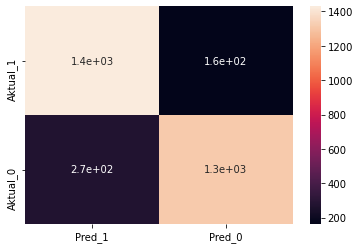

In [289]:
sns.heatmap(df_cm_XGB_Tuned,annot=True)

    nilai recall pada xgboost setelah dituning malah turun, harus di explore lebih lagi pada bagian tuning, agar dapat hasil maksimal. Nilai FN pada confusion matrix juga malah meningkat setelag di tuning.
    

In [292]:
data= {
    "KNN" : [recall_KNN_test],
    "KNN_Scaled" : [recall_KNN_test_scaled],
    "Random_Forest" : [recall_RF_test],
    "XGBoost" : [recall_XGB_test],
    "KNN_Tuned" : [recall_KNN_Tuned_test],
    "Random_Forest_Tuned" : [recall_RF_Tuned_test],
    "XGBoost_Tuned" : [recall_XGB_Tuned_test]
}
pd.DataFrame(data=data, index=['Recall']).T

,Recall
KNN,0.834903
KNN_Scaled,0.919648
Random_Forest,0.983679
XGBoost,0.936598
KNN_Tuned,0.955430
Random_Forest_Tuned,0.986817
XGBoost_Tuned,0.897050


     MODEL TERBAIK ADALAH : KNN Tuned, kenapa karena paling normal dibanding yang lain, Random forest tuned bisa menjadi opsi, namun model tersebut terlalu pintar. KNN tuned menurut saya paling sempurna untuk dipilih, nilai recal tidak overfit, cukup tinggi pula dengan angka 0.955430, dan nilai False Negative nya juga sedikit, yaitu 71 ==> Artinya model menebak nasabah sebagai 0, padahal aktualnya nasabah 1 ==> sudah cukup kecil tebakan errornya

# KESIMPULAN DAN SARAN

## KESIMPULAN
    1. Feature yang memiliki pengaruh dan perlu mendapat perhatian lebih adalah jika Nasabah : 
        - Letak georafisnya berada pada negara German, butuh perhatian lebih agar tetap bertahan, karena memiliki probabilitas untuk keluar tertinggi = 32.44%
        - Gendernya Female, probabilitasnya untuk keluar tinggi, yaitu 25.07%
        - Berusia diantara 44-92 tahun, kemungkinan keluarnya cukup tinggi, yaitu 44.62%
        - Baru memiliki tabungan di bank kita dibawah 1 tahun, cedederung akan keluar, dengan kemungkinan 23%
        - Jumlah produk pada bank kita tinggi, misalnya 3 dan 4, 3 pada 82% kemungkinannya keluar, dan untuk jumlah produk 4 kemungkinan keluarnya 100%
        - Member yang passive kemungkinan keluarnya 26.85%
    2. Model terbaik yang paling sempurna untuk digunakan dengan nilai recall tinggi(tidak overfitting) dan nilai False Negative cederung rendah. (karena fokus adalah menurunkan False negative ==> yang di prediksi model sebagai 0 ( tidak keluar) padahal aktualnya nasabah adalah 1(akan keluar) ==> DAPAT MENGURANGI JUMLAH NASABAH YANG AKAN KELUAR ==> MAKA DARI ITU FOKUS PADA RECALL)
    
    
## SARAN
    1. Untuk Feature:
        - Lebih banyak produk atau penawaran menarik untuk nasabah german, untuk mengurangi tingkat kemungkinan mereka akan keluar.
        - Menyediakan fitur khusus wanita, mungkin atm tp akses dibatasi cuman untuk wanita, merasa lebih di prioritaskan dan diharapkan dapat mengurangi tingkat kemungkinan wanita untuk menutup akunnya.
        - Menyediakan produk menggiurkan untuk usia diatas 44 tahun, mungkin untuk paket pensiun atau asuransi, dll.
        - Menyediakan keuntungan pada nasabah baru, agar lebih tertarik untuk tetap setia pada bank kita, atau menyediakan produk yang jatuh temponya cukup lama, sehingga mereka dapat bertahan lebih lama.
        - Hindari untuk menawarkan nasabah yang sudah memiliki 2 produk pada bank kita, karena angka kemungkinan keluar untuk yang memiliki diatas 2 produk cenderung sangat tinggi
        - Melakukan follow-up secara berkala kepada nasabah, agar lebih aktif.
        
    2. Melakukan explore lebih lanjut pada model random forest dan xgboost ==> khususnya di tuning, parameter-parameter yang kiranya penting untuk menaikkan nilai recall dan menurunkan FALS NEGATIVE. Karena base modelnya saja sudah sangat sempurna, model terlalu sempurna, mungkin di tuning agar menjadi lebih normal sedikit.
    

# IMPORT MODEL

In [294]:
joblib.dump(KNN_Tuned,"Predict_Bank_Exit")

['Predict_Bank_Exit']